In [1]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import os, json
import glob
import csv
import re
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import pandas as pd

from collections import Counter
import spacy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import numpy as np
import re
from string import punctuation
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import itertools

from textatistic import Textatistic
from tabulate import tabulate

All data downloaded from the following links:

Trip Advisor Dataset: http://times.cs.uiuc.edu/~wang296/Data/ Contains reviews for almost 2,000 hotels. Each review also contains variables for overall rating of the hotel (out of 5), ratings for Value, Service, and Cleanliness, and whether others found the review helpful.

Yelp Data: https://www.yelp.com/dataset/ The yelp dataset contains reviews for businesses, including hotels and restaurants. The review dataset also has variables for number of stars reviewers left, number of 'likes' that review received, date of review, among other variables.

## NLP Final Project --- Preparing the Data

The goal of this section is to reduce the amount of data we're dealing with, and do some cleaning to ensure we have all the information we need for the NLP.

First we'll start with the Yelp data, then move on to Trip Advisor. All data was downloaded in multiple json files.

### Yelp data

The Yelp data I'm using comes in two files: one with all the businesses data, and one with all the reviews.

In [2]:
## reading in business file
data = [json.loads(line) for line in open('business.json', 'r', encoding='utf8')]

## putting them in a pandas dataframe because I'm more comfortable tranforming data this way
yelp_business = pd.DataFrame.from_dict(json_normalize(data), orient='columns')

In [3]:
yelp_business.head(n=2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,attributes.BYOBCorkage,attributes.DriveThru,attributes.Smoking,attributes.AgesAllowed,attributes.HairSpecializesIn,attributes.Corkage,attributes.BYOB,attributes.DietaryRestrictions,attributes.Open24Hours,attributes.RestaurantsCounterService
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
## the dataset has 192,609 businesses in it
yelp_business.shape

(192609, 60)

Since both the Yelp dataset and the TripAdvisor dataset have many reviews for Phoenix AZ between them, I'm limiting both datsets to only include hotels from Phoenix.

In [5]:
## filtering by state -- there are 56,686 businesses in Arizona
yelp_AZ_id = yelp_business[yelp_business['state'].str.contains('AZ')]
yelp_AZ_id.shape

(56686, 60)

In [6]:
## filtering by city --we now have 18,774 businesses, which is a bit better
yelp_AZ_p_id = yelp_AZ_id[yelp_AZ_id['city'].str.contains('Phoenix')]
yelp_AZ_p_id.shape

(18774, 60)

Now the dataset is smaller, but it still has ALL businesses from Phoenix, AZ included in it. Though we can filter under the categories column for "Hotels", this will also include other non-hotel, "hotel-related" businesses (ex. Taxi services, Spas, Airports, etc).

In [7]:
## dropping businesses without a category
yelp_AZ_p_id_na = yelp_AZ_p_id.dropna(subset=['categories'])

## narrowed down to 607 hotel-related businesses in AZ
AZ_yelp_id = yelp_AZ_p_id_na[yelp_AZ_p_id_na['categories'].str.contains('Hotel')]
AZ_yelp_id.shape

(607, 60)

In [8]:
AZ_yelp_id.head(n=2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,attributes.BYOBCorkage,attributes.DriveThru,attributes.Smoking,attributes.AgesAllowed,attributes.HairSpecializesIn,attributes.Corkage,attributes.BYOB,attributes.DietaryRestrictions,attributes.Open24Hours,attributes.RestaurantsCounterService
395,Ao8DPAkiK7-wNlTsvHwnhw,Enterprise Rent-A-Car,122 N 2nd St,Phoenix,AZ,85004,33.449909,-112.071322,2.5,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
520,rFNWQd01kOhLVAjftZAzrw,BG Wild,"1 N 1st St, Ste 775",Phoenix,AZ,85004,33.457064,-112.072552,4.5,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here I read in the review file, which is the biggest takes some time.

In [9]:
## reading in reviews -- there might be a more effcient way to do this
yelp_data = [json.loads(line) for line in open('review.json', 'r', encoding='utf8')]

In [10]:
## 6,685,900 reviews total!
len(yelp_data)

6685900

In [11]:
## here is what one looks like
yelp_data[0]

{'review_id': 'Q1sbwvVQXV2734tPgoKj4Q',
 'user_id': 'hG7b0MtEbXx5QzbzE6C_VA',
 'business_id': 'ujmEBvifdJM6h6RLv4wQIg',
 'stars': 1.0,
 'useful': 6,
 'funny': 1,
 'cool': 0,
 'text': 'Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.',
 'date': '2013-05-07 04:34:36'}

Here I read out the id file as a csv in case I want to use it later.

In [12]:
## writing out business id file
AZ_yelp_id.to_csv(r'AZ_yelp_id.csv', index=None, header=True)

### TripAdvisor data

The TripAdvisor data comes in a bucketload of json files, so I'll need to go into that folder and loop thorugh all the files to get all the data into one object.

In [13]:
## setting the path to the files
path_to_json = 'C:/Users/pantalaimon/Desktop/NLP/Final Project/json'

## getting a list of all the json files I want to merge
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

In [14]:
## checking to see if it grabbed all 12,773 files --- it did!
len(json_files)

12773

In [15]:
## getting dictionary of indexed json files
allFilesDict = {v:k for v, k in enumerate(json_files, 0)}

In [16]:
## looping through the files and bringing in all the data

ta_data = []

for _, file in allFilesDict.items():
    with open(path_to_json + '/' + file, 'r') as d:
        jdata = json.load(d)
        ta_data.append(jdata)

In [17]:
## now we have each hotel and their reviews nested inside a list
len(ta_data)

12773

In [18]:
## here's an example of what the data regarding the hotel looks like
ta_data[0]['HotelInfo']

{'Name': 'Hilton Garden Inn Baltimore White Marsh',
 'HotelURL': '/ShowUserReviews-g60811-d100407-Reviews-Hilton_Garden_Inn_Baltimore_White_Marsh-Baltimore_Maryland.html',
 'Price': '$135 - $193*',
 'Address': '<address><span rel="v:address"><span dir="ltr"><span class="street-address" property="v:street-address">5015 Campbell Blvd</span>, <span class="locality"><span property="v:locality">Baltimore</span>, <span property="v:region">MD</span> <span property="v:postal-code">21236</span></span> </span></span></address>',
 'HotelID': '100407',
 'ImgURL': 'http://media-cdn.tripadvisor.com/media/ProviderThumbnails/dirs/40/b6/40b613427a5bd614b3f489b31d7756ec5large.jpg'}

In [19]:
## here is what one review looks like
ta_data[0]['Reviews'][0]

{'Ratings': {'Service': '5',
  'Cleanliness': '5',
  'Overall': '5.0',
  'Value': '5',
  'Sleep Quality': '5',
  'Rooms': '5',
  'Location': '5'},
 'AuthorLocation': 'Jacksonville, Florida',
 'Title': '“Great place and location”',
 'Author': 'Nadine R',
 'ReviewID': 'UR128178025',
 'Content': 'Usually stay near the airport, but this trip we had business on the north side of Balto. The traffic is too crazy staying elsewhere. This hotel was perfect, the hot breakfast wonderful - recommend getting the breakfast package if there are 2 of you in the room. Only hotel in the area with a restaurant and bar. This area does not have a whole lot of good restaurants (compared to staying near Columbia or Pikesville or off 83). It is next to White Marsh Mall which is a huge complex of shopping including an Ikea. The beds were fabulous - you can adjust your side for firmness.',
 'Date': 'April 19, 2012'}

Oddly, TripAdvisor does not include an overall score for each hotel like Yelp does (the only score available are the individul ones left by each reviewer). So here I'll create an average score for each hotel.

In [20]:
## looping through each hotel and each review to pull out the "Overall" rating

for i in ta_data:
    r = i['Reviews']
    overall = []
    i['HotelInfo']['Overall'] = overall
    for x in r:
        c = float(x['Ratings']['Overall'])
        overall.append(c)

At this point I wanted to make a dataframe of all the hotels we grabbed, since I'm more comfortable with pandas and I want to merge this dataset with the Yelp dataset later.

In [21]:
## subsetting the hotel data, since we're not interested in the review text yet
ta_subset = []

for i in ta_data:
    i['HotelInfo']['Overall'] = np.mean(i['HotelInfo']['Overall'])
    i['HotelInfo']['Review Count'] = len(i['Reviews'])
    r = i['HotelInfo']
    ta_subset.append(r)

len(ta_subset)

12773

In [22]:
## making the pandas dataframe
ta_df = pd.DataFrame.from_dict(json_normalize(ta_subset), orient='columns')

In [23]:
## checking that the dataframe has all hotels
ta_df.shape

(12773, 8)

In [24]:
## looking at the dataframe, the Reviews column has all the reviews for that hotel in it
ta_df.head(n=2)

,Name,HotelURL,Price,Address,HotelID,ImgURL,Overall,Review Count
0,Hilton Garden Inn Baltimore White Marsh,/ShowUserReviews-g60811-d100407-Reviews-Hilton...,$135 - $193*,"<address><span rel=""v:address""><span dir=""ltr""...",100407,http://media-cdn.tripadvisor.com/media/Provide...,4.444444,36
1,Hotel Monaco Seattle - a Kimpton Hotel,/ShowUserReviews-g60878-d100504-Reviews-Hotel_...,$184 - $345*,"<address class=""addressReset""> <span rel=""v:ad...",100504,http://media-cdn.tripadvisor.com/media/photo-s...,4.481043,422


#### Using RegEx to clean up addresses

It looks like the address column of the database is a jumble of html, so I'll use regex to pull out the state and city and add it to a new column in the dataframe

In [25]:
## here's an example of the text I'm trying to pull the state/city out of
ta_df['Address'][0]

'<address><span rel="v:address"><span dir="ltr"><span class="street-address" property="v:street-address">5015 Campbell Blvd</span>, <span class="locality"><span property="v:locality">Baltimore</span>, <span property="v:region">MD</span> <span property="v:postal-code">21236</span></span> </span></span></address>'

In [26]:
## testing my regex
test_state = re.findall(r'"v:region">(.*?)</span>', ta_df['Address'][0])
test_state

['MD']

In [27]:
## testing again for cities
test_city = re.findall(r'"v:locality">(.*?)</span>', ta_df['Address'][0])
test_city

['Baltimore']

In [28]:
## testing again for street address
test_address = re.findall(r'"v:street-address">(.*?)</span>', ta_df['Address'][0])
test_address

['5015 Campbell Blvd']

In [29]:
## one more time for postal code
test_code = re.findall(r'"v:postal-code">(.*?)</span>', ta_df['Address'][0])
test_code

['21236']

In [30]:
## using regex to pull out the state of each hotel and add it to a new columns
ta_df['State'] = ta_df['Address'].str.extract(r'"v:region">(.*?)</span>')

In [31]:
## using regex to pull out the city of each hotel and add it to a new columns
ta_df['City'] = ta_df['Address'].str.extract(r'"v:locality">(.*?)</span>')

In [32]:
## using regex to pull out the address of each hotel and add it to a new columns
ta_df['Street'] = ta_df['Address'].str.extract(r'"v:street-address">(.*?)</span>')

In [33]:
## using regex to pull out the postal code of each hotel and add it to a new columns
ta_df['Code'] = ta_df['Address'].str.extract(r'"v:postal-code">(.*?)</span>')

In [34]:
## looking at the new dataframe -- seems ok!
ta_df.head()

,Name,HotelURL,Price,Address,HotelID,ImgURL,Overall,Review Count,State,City,Street,Code
0,Hilton Garden Inn Baltimore White Marsh,/ShowUserReviews-g60811-d100407-Reviews-Hilton...,$135 - $193*,"<address><span rel=""v:address""><span dir=""ltr""...",100407,http://media-cdn.tripadvisor.com/media/Provide...,4.444444,36,MD,Baltimore,5015 Campbell Blvd,21236
1,Hotel Monaco Seattle - a Kimpton Hotel,/ShowUserReviews-g60878-d100504-Reviews-Hotel_...,$184 - $345*,"<address class=""addressReset""> <span rel=""v:ad...",100504,http://media-cdn.tripadvisor.com/media/photo-s...,4.481043,422,WA,Seattle,1101 Fourth Avenue,98101
2,Warwick Seattle Hotel,/ShowUserReviews-g60878-d100505-Reviews-Warwic...,$129 - $228*,"<address class=""addressReset""> <span rel=""v:ad...",100505,http://media-cdn.tripadvisor.com/media/photo-s...,3.567114,298,WA,Seattle,401 Lenora Street,98121
3,Hotel Seattle,/ShowUserReviews-g60878-d100506-Reviews-Hotel_...,$96 - $118*,"<address class=""addressReset""> <span rel=""v:ad...",100506,http://media-cdn.tripadvisor.com/media/Provide...,1.666667,48,WA,Seattle,315 Seneca St.,98101
4,Inn at the Market,/ShowUserReviews-g60878-d100507-Reviews-Inn_at...,$199 - $299*,"<address class=""addressReset""> <span rel=""v:ad...",100507,http://media-cdn.tripadvisor.com/media/photo-s...,4.715370,527,WA,Seattle,86 Pine St.,98101


Now that the big dataframe is clean(er) and organized, I'll filter out for Arizona.

In [35]:
## checking to see how many NaN rows we have in the state column -- it's a lot
ta_df.isna().sum()

Name            2765
HotelURL          31
Price              0
Address         2765
HotelID            0
ImgURL          2765
Overall           27
Review Count       0
State           8467
City            3206
Street          3033
Code            3433
dtype: int64

There are a lot of NA rows in the state column, but that's because there are a lot of international hotels included in the dataset. There is also a lot of missing data under Address, so I'm actually ok with moving forward at this point.

In [36]:
## dropping NAs from state column
ta_df_dropna = ta_df.dropna(subset=['State'])

## we're left with 183 hotels in Arizona
AZ_ta_df = ta_df_dropna[ta_df_dropna['State'].str.contains('AZ')]
AZ_ta_df.shape

(183, 12)

In [37]:
## and they're all from Phoenix
AZ_ta_df['City'].unique().tolist()

['Phoenix']

All of the hotels that TripAdvisor has reviews for in Arizona are from Phoenix, so we're done filtering the data for now.

In [38]:
## writing out hotel id file for safe keeping
AZ_ta_df.to_csv(r'AZ_ta_id.csv', index=None, header=True)

### Time to Merge

The Yelp dataset still has businesses that clearly aren't hotels, but hopefully when match using business name we will drop this false positives.

In [39]:
## doing an inner join to keep only hotels from Yelp and TripAdvisor that have the same name
merged_hotels = pd.merge(left=AZ_yelp_id,right=AZ_ta_df, left_on='name', right_on='Name')

In [40]:
## we're left with 50 matches, which feels like an ok number to work with
merged_hotels.shape

(50, 72)

In [41]:
## looks like we have some duplicates, but the addresses are matching up across datasets so I'm not too mad about it
merged_hotels.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Price,Address,HotelID,ImgURL,Overall,Review Count,State,City,Street,Code
0,Sxe7h922Dqv9HzfTH-8O7w,Courtyard by Marriott Phoenix North,9631 North Black Canyon Highway,Phoenix,AZ,85021,33.573841,-112.115881,3.5,21,...,$90 - $147*,"<address class=""addressReset""><span rel=""v:add...",73751,http://media-cdn.tripadvisor.com/media/Provide...,3.842105,19,AZ,Phoenix,9631 North Black Canyon Highway,85021
1,DNj1wGcCjuc-9HmfiEvRGA,La Quinta Inn Phoenix - Arcadia,4727 East Thomas Rd,Phoenix,AZ,85018,33.479738,-111.979801,2.5,31,...,$58 - $77*,"<address class=""addressReset""><span rel=""v:add...",2516205,http://media-cdn.tripadvisor.com/media/Provide...,3.603774,53,AZ,Phoenix,4727 East Thomas Road,85018
2,DNj1wGcCjuc-9HmfiEvRGA,La Quinta Inn Phoenix - Arcadia,4727 East Thomas Rd,Phoenix,AZ,85018,33.479738,-111.979801,2.5,31,...,$58 - $77*,"<address class=""addressReset""><span rel=""v:add...",74758,http://media-cdn.tripadvisor.com/media/Provide...,3.620000,50,AZ,Phoenix,4727 East Thomas Road,85018
3,JrlWOpx0n6SgQQrZuv9u1Q,Sheraton Crescent Hotel,2620 West Dunlap Ave,Phoenix,AZ,85021,33.568515,-112.115747,3.0,140,...,$90 - $172*,"<address class=""addressReset""><span rel=""v:add...",2516186,http://media-cdn.tripadvisor.com/media/photo-s...,4.182353,170,AZ,Phoenix,2620 West Dunlap Avenue,85021
4,JrlWOpx0n6SgQQrZuv9u1Q,Sheraton Crescent Hotel,2620 West Dunlap Ave,Phoenix,AZ,85021,33.568515,-112.115747,3.0,140,...,$90 - $172*,"<address class=""addressReset""><span rel=""v:add...",73947,http://media-cdn.tripadvisor.com/media/photo-s...,4.171779,163,AZ,Phoenix,2620 West Dunlap Avenue,85021


While eyeballing the data, it's apparent that the TripAdvisor dataset had some duplicates. This is a bit odd, since all of the data appears exactly the same (including the address), which the exception of the HotelID variable. This would imply they are the same hotels, and possibly the same reviews.

For now I'll keep the version that has more reviews.

In [42]:
## I can see there are duplicated Yelp hotels, but what about duplicated TA hotels?
dupe_test1 = merged_hotels[merged_hotels.duplicated(['HotelID'], keep=False)]

## there is a dupe, but only the second one matches on address
dupe_test1

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Price,Address,HotelID,ImgURL,Overall,Review Count,State,City,Street,Code
24,bphFS_7xYag4Dv_6d8fmVQ,Budget Suites of America,2702 W Yorkshire Dr,Phoenix,AZ,85027,33.663185,-112.117569,2.5,15,...,$99*,"<address class=""addressReset""><span rel=""v:add...",119366,http://media-cdn.tripadvisor.com/media/photo-s...,2.6,10,AZ,Phoenix,611 West Indian School Road,85013
25,G5ud7F7F4HglJAxwnbs9vQ,Budget Suites of America,611 W Indian School Rd,Phoenix,AZ,85013,33.493805,-112.081941,1.5,11,...,$99*,"<address class=""addressReset""><span rel=""v:add...",119366,http://media-cdn.tripadvisor.com/media/photo-s...,2.6,10,AZ,Phoenix,611 West Indian School Road,85013


There only appears to be one mis-match, so I'll delete that one and keep the rest.

In [43]:
hotels_2 = merged_hotels.drop_duplicates(subset=['HotelID'], keep="last")
hotels_2.shape

(49, 72)

In [44]:
dupe_test2 = hotels_2[hotels_2.duplicated(['business_id'], keep=False)].sort_values(by=['business_id', 'Review Count'])

## 2nd dupe test shows more dupes, so I'll drop the ones with fewer reviews
dupe_test2.shape

(28, 72)

In [45]:
## sorting by review count and then dropping the dupes
hotels_final = hotels_2.sort_values(by=['business_id', 'Review Count']).drop_duplicates(subset=['business_id'], keep="last")

hotels_final.shape

(35, 72)

The final dataframe has 35 hotels.

In [46]:
## save to disk for safekeeping
hotels_final.to_csv(r'hotels_final.csv', index=None, header=True)

### Getting the reviews into a corpus

Now that I've identified the 35 hotels I'm comparing reviews for, it's time to actually gather the reviews into a corpus that I can export and use for analysis.

In [47]:
## grabbing the hotel id numbers for yelp
yelp_hotels = hotels_final['business_id'].unique().tolist()
len(yelp_hotels)

35

In [48]:
## grabbing the hotel id numbers for ta
ta_hotels = hotels_final['HotelID'].unique().tolist()
len(ta_hotels)

35

The review data for TA is still in ta_data, but we need to loop through it to pull out only the reviews for the 49 hotels we've chosen.

In [49]:
## looping through the hotels to grab only the matched ones
ta_az = [i for i in ta_data if i['HotelInfo']['HotelID'] in ta_hotels]

## now we have a list of all the hotels we chose and the reviews for each of them
len(ta_az)

35

Now I'll build the corpus for the Yelp data

In [50]:
## looping through the hotels to grab only the matched ones
yelp_az = [i for i in yelp_data if i['business_id'] in yelp_hotels]

## now we have a list of all the reviews for each hotel that we chose
len(yelp_az)

3572

In [51]:
## save to disk
with open('ta_az.txt', 'w') as file:
    file.write(json.dumps(ta_az))

In [52]:
## save to disk
with open('yelp_az.txt', 'w') as file:
    file.write(json.dumps(yelp_az))

## Final Project -- NLP Analysis

In this section, my goal was to conduct an exploratory natural language processing analysis that would compare reviews across platforms and reviews any differences in review length, language style/readability, and topic/theme.

My analysis used readability measures included in Textastic(), word and sentance counts per review and tf-idf. I also included an addendum where I attempted an exploratory topic analysis using POS taggin, although it didn't quite work out!

In [4]:
## opening TripAdvisor corpus
with open('ta_az.txt') as text:
    ta_data = eval(text.read())

In [5]:
## opening Yelp corpus
with open('yelp_az.txt') as text:
    yelp_data = eval(text.read())

In [55]:
## opening the hotel attribute file
hotels = pd.read_csv('hotels_final.csv')

In [56]:
## taking a peek at the hotel dataframe
hotels.shape

(35, 72)

At this point I realized that the best way to analyze the texts might be to compare positive reviews and negative reviews across platforms. My thinking here is that highly positive/negative reviews are likely to be more emotional in tone.

Before dividing up the corpuses into positive/negative reviews however, I decided to do a quick exploratory analysis using the hotels dataframe to see what summary statistics can tell us about both datasets.

### Exploratory Analysis

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000249C2FA0588>],
      dtype=object)

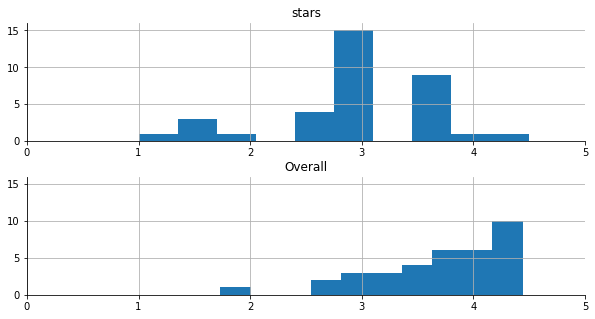

In [57]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

## getting rid of gross lines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.set_xlim(0,5)
ax2.set_xlim(0,5)
ax1.set_ylim(0,16)
ax2.set_ylim(0,16)

## plotting Yelp on the first graph and Tripadvisor on the second
hotels.hist(column='stars', ax=ax1)
hotels.hist(column='Overall', ax=ax2)

The histograms above show the distribution of hotels by their average rating. Looking at them side by side, it appears that TripAdvisor has more hotels with higher ratings. Yelp, on the other hand, has a lot of hotels with "neutral", or 3-star ratings.

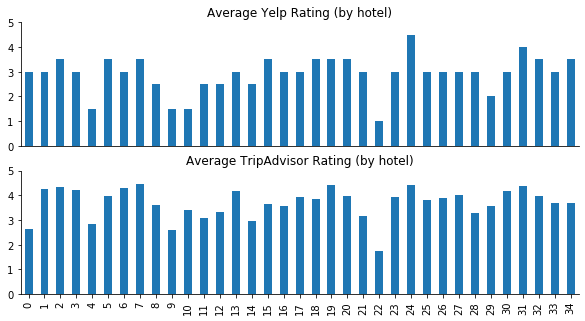

In [58]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

## getting rid of gross lines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.set_title('Average Yelp Rating (by hotel)')
ax2.set_title('Average TripAdvisor Rating (by hotel)')

ax1.set_ylim(0,5)
ax2.set_ylim(0,5)

## plotting Yelp on the first graph and Tripadvisor on the second
hotels.plot.bar(y='stars', ax=ax1, legend=False)
hotels.plot.bar(y='Overall', ax=ax2, legend=False)

It looks like TripAdvisor reviews do tend to be higher for individual hotels on average.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000249E868FE48>],
      dtype=object)

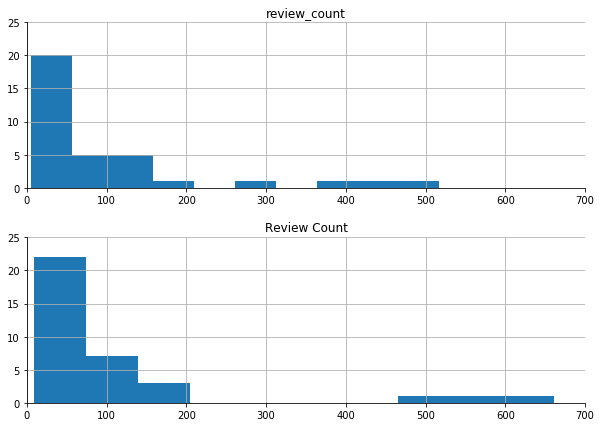

In [59]:
fig = plt.figure(figsize=(10,7))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

## getting rid of gross lines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.set_xlim(0,700)
ax2.set_xlim(0,700)
ax1.set_ylim(0,25)
ax2.set_ylim(0,25)

## plotting Yelp on the first graph and Tripadvisor on the second
hotels.hist(column='review_count', ax=ax1)
hotels.hist(column='Review Count', ax=ax2)

Looking at the distribution of reviews across platforms, it looks like most hotels on both Yelp and TripAdvisor have fewer than 100 reviews, with the exception of a few hotels that have close to 500.

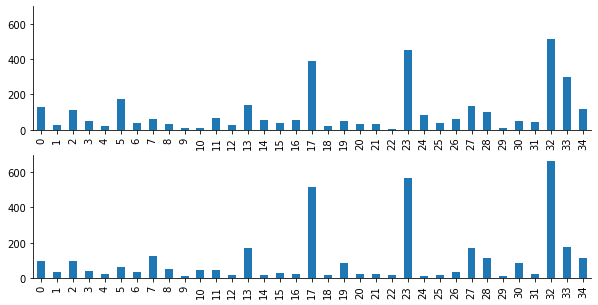

In [60]:
## setting up the plot
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

## getting rid of gross lines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.set_ylim(0,700)
ax2.set_ylim(0,700)

## plotting Yelp on the first graph and Tripadvisor on the second
hotels.plot.bar(y='review_count', ax=ax1, legend=False)
hotels.plot.bar(y='Review Count', ax=ax2, legend=False)

Comparing number of reviews hotel-by-hotel, the bar charts for Yelp and TripAdvisor look very similiar. There also doesn't appear to be any major relationship between hotel rating and number of reviews, so we can probably assume that the hotels above with lots and lots of reviews are just more popular in general.

### Cleaning up both corpuses

Both text documents still have the reviews and the associated review data in them, so I still need to loop through both and isolate the review text itself.

In [6]:
## loopin through the TA data
ta_reviews = []

for i in ta_data:
    r = i['Reviews']
    for x in r:
        c = x['Content']
        ta_reviews.append(c)

## there are 3582 TA reviews
len(ta_reviews)

## ta_reviews is the list of strings, each item is a review

3582

In [62]:
## looopin through the yelp data
yelp_reviews = []

for i in yelp_data:
    r = i['text']
    yelp_reviews.append(r)

## there are 3572 yelp reviews
len(yelp_reviews)

## yelp_reviews is the list of strings, each item is a review

3572

In [63]:
## here I'm joining all the reviews into one giant corpus
yelp_corp = ' '.join(yelp_reviews)
ta_corp = ' '.join(ta_reviews)

## I found some chinese words/characters in the reviews, so here I'm just dropping those characters
yelp_corp_asc = yelp_corp.encode("ascii", errors="ignore").decode()
ta_corp_asc = ta_corp.encode("ascii", errors="ignore").decode()

For my first method of analysis, I chose to look at readability and word count to see if there were any differences between the two platforms.

First for Yelp:

In [64]:
## getting an obeject for textatistic calculations -- first is Yelp
yelp_read = Textatistic(yelp_corp_asc)

## return dictionary of all attribute values
yelp_values = yelp_read.dict()

## putting them in a dataframe
df_yelp = pd.DataFrame(list(yelp_values.items()), columns= ['metric', 'yelp_value'])

In [65]:
## getting each count per-review by dividing by the number of reviews
df_yelp['yelp_perreview'] = df_yelp.iloc[0:6, 1]/len(yelp_reviews)

df_yelp

,metric,yelp_value,yelp_perreview
0,char_count,2.339187e+06,654.867581
1,word_count,5.341280e+05,149.531915
2,sent_count,4.308600e+04,12.062150
3,sybl_count,6.663110e+05,186.537234
4,notdalechall_count,8.253800e+04,23.106943
5,polysyblword_count,2.442400e+04,6.837626
6,flesch_score,8.871593e+01,NaN
7,fleschkincaid_score,3.964945e+00,NaN
8,gunningfog_score,6.787790e+00,NaN
9,smog_score,7.430256e+00,NaN


For Yelp, it looks like the average word count per review on yelp is about 150, and the average number of sentances is 12.

The Dale Chall score is also 6.69, which would indicate a reading level of an average 7th or 8th grader.

Now for TripAdvisor:

In [66]:
## getting an obeject for textatistic calculations -- now TripAdvisor
ta_read = Textatistic(ta_corp_asc)

## return dictionary of all attribute values
ta_values = ta_read.dict()

## putting them in a dataframe
df_ta = pd.DataFrame(list(ta_values.items()), columns= ['metric', 'ta_value'])

In [67]:
## getting each count per-review by dividing by the number of reviews
df_ta['ta_perreview'] = df_ta.iloc[0:6, 1]/len(ta_reviews)

df_ta

,metric,ta_value,ta_perreview
0,char_count,2.826932e+06,789.204913
1,word_count,6.379000e+05,178.084869
2,sent_count,4.671000e+04,13.040201
3,sybl_count,8.053370e+05,224.828867
4,notdalechall_count,1.032910e+05,28.836125
5,polysyblword_count,3.226700e+04,9.008096
6,flesch_score,8.616760e+01,NaN
7,fleschkincaid_score,4.633358e+00,NaN
8,gunningfog_score,7.485968e+00,NaN
9,smog_score,7.877194e+00,NaN


For TripAdvisor, it looks like the average word count is slightly higher at 178 words per review. The Dale Chall score is pretty much the same as well.

### Getting the tf-idf together

Before looking at positive and negative reviews seperately, I wanted to do a quick comparison of the overall topics between both platforms.

Here I decided to keep some punctuation, since the text data was very clean and looking at the number of "!"s and "?"s might be interesting. I also thought I'd keep first-person pronouns, as it might be interesting to see how frequently reviewers across platforms talked about themselves!

In [68]:
## putting the corpuses into a dictionary where the keys are the platform
all_dict = {'yelp': yelp_corp_asc, 'ta': ta_corp_asc}

reviews = list(all_dict.values())
## so reviews is a list of 2, consisting of the yelp reviews and the ta reviews

In [69]:
## getting my personalized list of stopwords
keep_punc = ['!', '?', '$']
keep_words = ['we', 'me', 'my', 'mine', 'myself', 'our', 'ours']
punct2 = [elem for elem in list(punctuation) if elem not in keep_punc]
words2 = [elem for elem in stopwords.words('english') if elem not in keep_words]

stop_words = words2 + punct2

In [70]:
clean_reviews = []

## the cleaning
for x in reviews:
    x = word_tokenize(x)
    x = [w.lower() for w in x]
    x = [w for w in x if w not in stop_words]
    x = [w for w in x if w.isdigit()==False]
    clean_reviews.append(x)

## clean_reviews is the list of yelp and ta reviews containing the lists of cleaned tokenized words
len(clean_reviews)

2

In [71]:
## now turning the list of tokenized words back into two large strings so I can plug them into the vectorizor
reviews_str = [" ".join(x) for x in clean_reviews]

## this is for indexing
platform = ['Yelp', 'TripAdvisor']

In [72]:
## I chose an n-gram range of 1 to 2
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words=None, token_pattern=r"(?u)\b\w\w+\b|!|\?|\$")
## I realized that the vectorizer function automatically gets rid of punctuation, so I had to add this regex to make sure it keeps "!", "?", and "$"

## the list of documents is 2, 1st is yelp 2nd is ta
vectors = vectorizer.fit_transform(reviews_str)

## getting the feature names
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()

## creating a dataframe with the feature names as columns and the platform as the row
df = pd.DataFrame(denselist, columns=feature_names, index=platform)

## finally, transposing
df_t = df.T

In [73]:
df_t.nlargest(20,'Yelp')['Yelp']

we         0.407992
room       0.303070
!          0.293210
my         0.281106
hotel      0.238743
our        0.164149
stay       0.141777
would      0.129537
me         0.129401
nice       0.126613
one        0.121718
great      0.121514
pool       0.121242
staff      0.111314
service    0.100978
get        0.100162
rooms      0.097306
place      0.096898
like       0.088534
us         0.088058
Name: Yelp, dtype: float64

In [74]:
df_t.nlargest(20,'TripAdvisor')['TripAdvisor']

we         0.523523
room       0.283717
hotel      0.245708
!          0.205424
our        0.201417
my         0.194000
pool       0.137040
stay       0.132329
great      0.131625
would      0.126373
nice       0.124153
one        0.120580
staff      0.117493
resort     0.109534
good       0.103362
service    0.095890
rooms      0.095403
area       0.093562
stayed     0.089176
us         0.085440
Name: TripAdvisor, dtype: float64

TripAdvisor has a lot of chatter about the pools! Yelp apparently has more !s though.

In [75]:
df.sort_values('!', ascending=False)['!']

Yelp           0.293210
TripAdvisor    0.205424
Name: !, dtype: float64

In [76]:
df.sort_values('$', ascending=False)['$']

TripAdvisor    0.070280
Yelp           0.060383
Name: $, dtype: float64

TripAdvisor might talk more about money!

### Comparing "bad" and "good" reviews for Yelp and TripAdvisor

Next, I'll repeat the analysis above but this time I'll create 4 corpuses with positive and negative reviews for each platform.

First, looping through the original corpuses to group them by rating.

In [77]:
## empty list where I'll keep all the bad reviews for yelp
bad_yelp = []

## looping through data to collect reviews with fewer than 3 stars
for i in yelp_data:
    r = i['text']
    if i['stars'] < 3:
        bad_yelp.append(r)

## there are 1204 bad reviews on yelp
len(bad_yelp)

1204

In [78]:
## taking a peek at the first bad review in the list
bad_yelp[0]

"One of the crappier Marriotts I've ever stayed at. The staff is nice and professional enough. But the fact that it's right by the frontage road along I-17, you tend to attract a seedier crowd. Also, with three floors worth of rooms here, guess how many washer/dryer they have for everyone? ONE crappy washer and ONE crappy dryer! Don't even think about washing your clothes on a Friday night. For a two hour period, I went to see if the washer was finally available, each time I was met with yet another load of dirty clothes inside. If they can't afford to get more machines, consider installing one of those number ticket dispensers! Just a thought. Maybe I would have a better shot of washing my clothes. I also considered sitting on top of the washer until the load was done, but that would be kind of creepy on my part. I will be packing all my dirty clothes with me and never come back here again."

In [79]:
## empty list where I'll keep all the bad reviews for TA
bad_ta = []

## looping through data to collect reviews less than a 3 out of 5
for i in ta_data:
    r = i['Reviews']
    for x in r:
        x['Ratings']['Overall'] = float(x['Ratings']['Overall'])
        if x['Ratings']['Overall'] < 3:
            bad_ta.append(x['Content'])

## there are 562 bad reviews on TripAdvisor
len(bad_ta)

562

In [80]:
## taking a peek at the first bad review in the list
bad_ta[0]

"I love character hotels, and rate some older hotels as my very favorites. But the San Carlos is just dingy and inadequate. The rooms look like a place you check in to kill yourself (maybe that's why the windows don't open): drab, featureless, and slighltly dirty. Cracked tiles throughout the tiny bathroom. No room service, no restaurant really on site (there is something called the Ghost Lounge, but it's just a dusty, joyless bar). The fitness center is a random room with a few machines scattered about, including a non-functioning treadmill. Ignorant staff -- I asked for directions to a meeting that was just two blocks away, and was sent in the opposite direction. And all this for $199 a night."

In [81]:
## empty list where I'll keep all the good reviews for yelp
good_yelp = []

## looping through data to collect reviews with more than 3 stars
for i in yelp_data:
    r = i['text']
    if i['stars'] > 3:
        good_yelp.append(r)

## there are 1758 bad reviews on yelp
len(good_yelp)

1758

In [82]:
## taking a peek at the first good review in the list
good_yelp[0]

'My company hosted a dinner and awards night at the hotel last night and the experience was the best we could have imagined! Working with Kristine Cole was fantastic and the communication was always on point. I walked in to be blown away by the set up and I had compliments on the food all night. I came into work today to be flooded with emails on how impressed everyone was with the presentation. The staff that was there to help us was GREAT! I believe Tim was in charge and he had Anna and one other gentleman with him and they made us laugh and gave us the privacy we needed. We will be back and I will be recommending them to everyone!'

In [83]:
## empty list where I'll keep all the good reviews for TA
good_ta = []

## looping through data to collect reviews less than a 3 out of 5
for i in ta_data:
    r = i['Reviews']
    for x in r:
        x['Ratings']['Overall'] = float(x['Ratings']['Overall'])
        if x['Ratings']['Overall'] > 3:
            good_ta.append(x['Content'])

## there are 2504 bad reviews on TripAdvisor
len(good_ta)

2504

In [84]:
## taking a peek at the first good review in the list
good_ta[0]

"Thank you, Thank you, to Event Coordinator Augustina Porter at the Hotel San Carlos. My daughter is getinng married next weekend and we will have a large party staying at the hotel. Augustina has been more then helpful!! From changing the bride's and family suites at the last minute, to corrdinating a fabulous mani/pedi party at a nearby salon for my daughter and her bridesmaids. I am more then satified with the excellent service so far and if her staff is half as attentive as she this promises to be a wonderful weekend!!!!!"

### Word Counts and Readability, Part 2

Now to re-do the clean up I did above.

In [85]:
## here I'm joining all the reviews into four giant corpuses
good_yelp_corp = ' '.join(good_yelp)
bad_yelp_corp = ' '.join(bad_yelp)
good_ta_corp = ' '.join(good_ta)
bad_ta_corp = ' '.join(bad_ta)

## I found some chinese words/characters in the reviews, so here I'm just dropping those characters
goodyelp_corp_asc = good_yelp_corp.encode("ascii", errors="ignore").decode()
badyelp_corp_asc = bad_yelp_corp.encode("ascii", errors="ignore").decode()
goodta_corp_asc = good_ta_corp.encode("ascii", errors="ignore").decode()
badta_corp_asc = bad_ta_corp.encode("ascii", errors="ignore").decode()

Now the corpuses are ready for the readability function.

First the "bad" reviews:

In [86]:
## getting an obeject for textatistic calculations -- first is bad reviews
badyelp_read = Textatistic(badyelp_corp_asc)
badta_read = Textatistic(badta_corp_asc)

## return dictionary of all attribute values
badyelp_values = badyelp_read.dict()
badta_values = badta_read.dict()

## putting them in a dataframe
bad1 = pd.DataFrame(list(badyelp_values.items()), columns= ['metric', 'yelp_value'])
bad2 = pd.DataFrame(list(badta_values.items()), columns= ['metric', 'ta_value'])

In [87]:
## merging the dataframes together and making a new column for counts per review
bad_df = pd.merge(left=bad1,right=bad2, left_on='metric', right_on='metric')
bad_df['yelp_perreview'] = bad_df.iloc[0:6, 1]/len(bad_yelp)
bad_df['ta_perreview'] = bad_df.iloc[0:6, 1]/len(bad_ta)

bad_df

,metric,yelp_value,ta_value,yelp_perreview,ta_perreview
0,char_count,935232.000000,546624.000000,776.770764,1664.113879
1,word_count,216256.000000,125524.000000,179.614618,384.797153
2,sent_count,17347.000000,9016.000000,14.407807,30.866548
3,sybl_count,268232.000000,156673.000000,222.784053,477.281139
4,notdalechall_count,30918.000000,18341.000000,25.679402,55.014235
5,polysyblword_count,9375.000000,5649.000000,7.786545,16.681495
6,flesch_score,89.248356,87.110166,NaN,NaN
7,fleschkincaid_score,3.907995,4.567911,NaN,NaN
8,gunningfog_score,6.720647,7.369078,NaN,NaN
9,smog_score,7.328801,7.651029,NaN,NaN


Wow, it looks like TripAdvisor users are actually MUCH more wordy than Yelpers when they're having a bad time, leaving 384-word reviews on average! They also write 30 sentences on average, which is double what unhappy Yelpers write.

Readability scores are also all very similiar between platforms. The one I'm keeping my eye on is the Dale Chall Score.

Now the "good" reviews:

In [88]:
## getting an obeject for textatistic calculations -- good reviews
goodyelp_read = Textatistic(goodyelp_corp_asc)
goodta_read = Textatistic(goodta_corp_asc)

## return dictionary of all attribute values
goodyelp_values = goodyelp_read.dict()
goodta_values = goodta_read.dict()

## putting them in a dataframe
good1 = pd.DataFrame(list(goodyelp_values.items()), columns= ['metric', 'yelp_value'])
good2 = pd.DataFrame(list(goodta_values.items()), columns= ['metric', 'ta_value'])

In [89]:
## merging the dataframes together and making a new column for counts per review
good_df = pd.merge(left=good1,right=good2, left_on='metric', right_on='metric')
good_df['yelp_perreview'] = good_df.iloc[0:6, 1]/len(good_yelp)
good_df['ta_perreview'] = good_df.iloc[0:6, 1]/len(good_ta)

good_df

,metric,yelp_value,ta_value,yelp_perreview,ta_perreview
0,char_count,967071.000000,1.788728e+06,550.097270,386.210463
1,word_count,217922.000000,4.003300e+05,123.960182,87.029553
2,sent_count,17858.000000,2.980400e+04,10.158134,7.131789
3,sybl_count,273774.000000,5.083870e+05,155.730375,109.334665
4,notdalechall_count,36005.000000,6.762000e+04,20.480660,14.378994
5,polysyblword_count,10643.000000,2.137800e+04,6.054039,4.250399
6,flesch_score,88.166475,8.576621e+01,NaN,NaN
7,fleschkincaid_score,3.993452,4.633569e+00,NaN,NaN
8,gunningfog_score,6.834762,7.508874e+00,NaN,NaN
9,smog_score,7.539323,7.967382e+00,NaN,NaN


Looks like on average, TripAdvisor reviewers keep it short and sweet when leaving a positive review with only 87 words! Yelpers are also slightly less wordy when leaving positive reviews, but they actually write more than happy TripAdvisor users!

Readability measures are again very similar.

### Td-idf, Part 2

Same as above, but this time we have 4 corpuses.

In [90]:
## putting the corpuses into a dictionary where the keys are the platform
all_dict2 = {'good_yelp': goodyelp_corp_asc, 'good_ta': goodta_corp_asc, 'bad_yelp': badyelp_corp_asc, 'bad_ta': badta_corp_asc}

reviews2 = list(all_dict2.values())
## so reviews is a list of 2, consisting of the yelp reviews and the ta reviews

In [91]:
## using same stopwords as above
clean_reviews2 = []

for x in reviews2:
    x = word_tokenize(x)
    x = [w.lower() for w in x]
    x = [w for w in x if w not in stop_words]
    x = [w for w in x if w.isdigit()==False]
    clean_reviews2.append(x)

## clean_reviews2 is the list of yelp and ta reviews containing the lists of cleaned tokenized words
len(clean_reviews2)

4

In [92]:
## now turning the list of tokenized words back into two large strings so I can plug them into the vectorizor
reviews_str2 = [" ".join(x) for x in clean_reviews2]

## this is for indexing
platform2 = ['Yelp (good)', 'TripAdvisor (good)', 'Yelp (bad)', 'TripAdvisor (bad)']

In [93]:
## I'm using the same model that I instantiated above, so I can just plug in the second round of corpuses
vectors = vectorizer.fit_transform(reviews_str2)

## getting the feature names
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()

## creating a dataframe with the feature names as columns and the platform as the row
df_2 = pd.DataFrame(denselist, columns=feature_names, index=platform2)

## finally, transposing
df_t_2 = df_2.T

Looking at "bad" reviews first!

In [94]:
df_t_2.nlargest(20,'Yelp (bad)')['Yelp (bad)']

we         0.428607
my         0.327682
room       0.308962
!          0.272173
hotel      0.220896
our        0.173527
me         0.168806
would      0.149597
stay       0.122575
one        0.117204
get        0.107925
front      0.093600
desk       0.093437
us         0.092461
service    0.089205
could      0.089042
night      0.088391
back       0.088228
! !        0.084484
?          0.083182
Name: Yelp (bad), dtype: float64

In [95]:
df_t_2.nlargest(20,'TripAdvisor (bad)')['TripAdvisor (bad)']

we         0.501131
room       0.350063
my         0.237393
hotel      0.232628
our        0.203760
!          0.191708
would      0.153590
stay       0.133411
one        0.119397
me         0.110428
night      0.102020
$          0.100338
get        0.100338
us         0.095854
desk       0.091089
could      0.089968
pool       0.087165
service    0.084643
rooms      0.081560
front      0.075674
Name: TripAdvisor (bad), dtype: float64

Looks like unhappy TripAdvisor users still talk a lot about the pool, but Yelpers use a lot of punctuation when they're upset. Bad TripAdvisor reviews also seem to talk about specific amounts of money more frequently, or possibly they use the dollar sign sign as shorthand.

Now for positive reviews:

In [96]:
df_t_2.nlargest(20,'Yelp (good)')['Yelp (good)']

we         0.380827
!          0.337205
room       0.261259
hotel      0.235369
my         0.223600
great      0.197239
nice       0.166955
stay       0.156442
our        0.153147
pool       0.142633
staff      0.139024
clean      0.115644
one        0.114232
service    0.107014
rooms      0.102778
place      0.102307
would      0.098698
good       0.094618
stayed     0.088185
me         0.088028
Name: Yelp (good), dtype: float64

In [97]:
df_t_2.nlargest(20,'TripAdvisor (good)')['TripAdvisor (good)']

we         0.530444
room       0.239397
hotel      0.233494
!          0.222098
our        0.203733
my         0.175202
great      0.167578
pool       0.149131
stay       0.135685
staff      0.133390
nice       0.133062
resort     0.120026
one        0.116009
would      0.109614
good       0.106745
area       0.102317
service    0.097644
stayed     0.093709
rooms      0.091577
clean      0.083789
Name: TripAdvisor (good), dtype: float64

Happy Yelpers seem to mention "clean" more often than TripAdvisor users, but otherwise they seem pretty similiar across platforms.

Next I'll look at some common terms that might come up in a hotel review to see how they differ across platforms and kinds of reviews.

In [98]:
df_2.sort_values('area', ascending=False)['area']

TripAdvisor (good)    0.102317
Yelp (good)           0.076573
TripAdvisor (bad)     0.050449
Yelp (bad)            0.040696
Name: area, dtype: float64

In [99]:
df_2.sort_values('location', ascending=False)['location']

TripAdvisor (good)    0.041075
Yelp (good)           0.039385
TripAdvisor (bad)     0.021861
Yelp (bad)            0.016441
Name: location, dtype: float64

In [100]:
df_2.sort_values('dirty', ascending=False)['dirty']

Yelp (bad)            0.029789
TripAdvisor (bad)     0.024944
Yelp (good)           0.002668
TripAdvisor (good)    0.000984
Name: dirty, dtype: float64

In [101]:
df_2.sort_values('expensive', ascending=False)['expensive']

TripAdvisor (good)    0.010494
TripAdvisor (bad)     0.007848
Yelp (bad)            0.006674
Yelp (good)           0.006276
Name: expensive, dtype: float64

In [102]:
df_2.sort_values('unfair', ascending=False)['unfair']

TripAdvisor (bad)     0.000686
Yelp (bad)            0.000199
TripAdvisor (good)    0.000100
Yelp (good)           0.000000
Name: unfair, dtype: float64

Hmm. Happy TripAdvisor users will mention that a place is expensive more than Yelpers. However this could be a factor of the particular hotels that got grouped into each category.

In [103]:
df_2.sort_values('ugly', ascending=False)['ugly']

Yelp (bad)            0.001139
Yelp (good)           0.000314
TripAdvisor (bad)     0.000280
TripAdvisor (good)    0.000246
Name: ugly, dtype: float64

Ouch. Yelpers (both happy and unhappy) use the term ugly more frequently than TripAdvisor users, even if it's a good review.

In [104]:
df_2.sort_values('shit', ascending=False)['shit']

Yelp (bad)            0.004673
Yelp (good)           0.000474
TripAdvisor (good)    0.000000
TripAdvisor (bad)     0.000000
Name: shit, dtype: float64

Yelpers are also not afriad to curse, but this may be due to TripAdvisor's profanity filter?

In [105]:
df_2.sort_values('disgusting', ascending=False)['disgusting']

Yelp (bad)            0.008953
TripAdvisor (bad)     0.004765
Yelp (good)           0.000785
TripAdvisor (good)    0.000082
Name: disgusting, dtype: float64

The word "disgusting" is not entirely uncommon across platforms for bad reviews, although Yelpers use is more frequently.

In [106]:
df_2.sort_values('nasty', ascending=False)['nasty']

Yelp (bad)            0.004721
TripAdvisor (bad)     0.001682
Yelp (good)           0.000628
TripAdvisor (good)    0.000164
Name: nasty, dtype: float64

In [107]:
df_2.sort_values('trendy', ascending=False)['trendy']

Yelp (good)           0.002303
TripAdvisor (good)    0.001304
Yelp (bad)            0.000398
TripAdvisor (bad)     0.000000
Name: trendy, dtype: float64

In [108]:
df_2.sort_values('party', ascending=False)['party']

TripAdvisor (bad)     0.008408
Yelp (bad)            0.008302
Yelp (good)           0.007846
TripAdvisor (good)    0.004099
Name: party, dtype: float64

This is a little interesting -- party seems to appear slightly more frequently in negative reviews than positive reviews.

## Final Project -- Addendum: Word of Speech Tagging

Originally, I had wanted to use POS tagging using spacy to see what kinds of adjectives users like to use to describe the same hotel-related verbs across platforms.

Ultimately I wasn't thrilled with the results, but I decided to leave in my work here for feedback/future experimental purposes!

In [109]:
nlp = spacy.load("en_core_web_sm")
## I have to set the max length here to the biggest corpus because spacy limits you -- my computer can handle it!
nlp.max_length = 2188325

## creating a tokenized and tagged document for good reviews on Yelp/TA
goody_nlp = nlp(goodyelp_corp_asc)
goodt_nlp = nlp(goodta_corp_asc)

## creating a tokenized and tagged document for bad reviews on Yelp/TA
bady_nlp = nlp(badyelp_corp_asc)
badt_nlp = nlp(badta_corp_asc)

### Linking nounds and adjectives

First I' thought I would see what the most common nouns are for bad yelp reviews using a simple word count. Then, I wanted to see what adjectives are commonly found "near" it.

Note: There is likely a better way to do this using the dependencies feature, but with the time I have I'll just be looking at adjectives that are right next to a noun.

As a test, I'll take a single review (below) as an example and loop through it to see what it returns.

In [125]:
bad_yelp[0]

"One of the crappier Marriotts I've ever stayed at. The staff is nice and professional enough. But the fact that it's right by the frontage road along I-17, you tend to attract a seedier crowd. Also, with three floors worth of rooms here, guess how many washer/dryer they have for everyone? ONE crappy washer and ONE crappy dryer! Don't even think about washing your clothes on a Friday night. For a two hour period, I went to see if the washer was finally available, each time I was met with yet another load of dirty clothes inside. If they can't afford to get more machines, consider installing one of those number ticket dispensers! Just a thought. Maybe I would have a better shot of washing my clothes. I also considered sitting on top of the washer until the load was done, but that would be kind of creepy on my part. I will be packing all my dirty clothes with me and never come back here again."

In [177]:
doc = nlp(bad_yelp[0])

## empty test list that wll hold the noun/adj pairs
test = []

## looping through the tagged object and collecting noun/adj pairs
## this loop works OK, it looks one word behind the noun then to the end of the document for the nearest adjective

for i,token in enumerate(doc):
    if token.pos_ not in ('NOUN','PROPN'):
        continue
    for j in range(i-1, len(doc)):
        if doc[j].pos_ == 'ADJ':
            test.append((str(token), str(doc[j])))
            break

test

[('Marriotts', 'crappier'),
 ('staff', 'nice'),
 ('fact', 'right'),
 ('frontage', 'seedier'),
 ('road', 'seedier'),
 ('I-17', 'seedier'),
 ('crowd', 'seedier'),
 ('floors', 'worth'),
 ('rooms', 'many'),
 ('washer', 'many'),
 ('dryer', 'crappy'),
 ('everyone', 'crappy'),
 ('washer', 'crappy'),
 ('dryer', 'crappy'),
 ('clothes', 'available'),
 ('Friday', 'available'),
 ('night', 'available'),
 ('hour', 'available'),
 ('period', 'available'),
 ('washer', 'available'),
 ('time', 'dirty'),
 ('load', 'dirty'),
 ('clothes', 'dirty'),
 ('machines', 'more'),
 ('number', 'better'),
 ('ticket', 'better'),
 ('dispensers', 'better'),
 ('thought', 'better'),
 ('shot', 'better'),
 ('clothes', 'creepy'),
 ('top', 'creepy'),
 ('washer', 'creepy'),
 ('load', 'creepy'),
 ('part', 'dirty'),
 ('clothes', 'dirty')]

Looks like this model has high recall, returning all of the nouns and multiple repeats of the same adjective closest to the noun. The model isn't as precise however, since it will sometimes return a false positive (ie, a word that isn't a noun) or will attribute an adjective to a noun that isn't really related to it (for example, "fact" and "right").

I wasn't too unhappy with the outcome howevers, since you can kind of tell by the list that this is likely a negative review!

In [110]:
## empty list for the noun/adj pairs
bady_pairs = []

## looping through the tagged object and collecting noun/adj pairs
for i,token in enumerate(bady_nlp):
    if token.pos_ not in ('NOUN','PROPN'):
        continue
    for j in range(i-1, len(bady_nlp)):
        if bady_nlp[j].pos_ == 'ADJ':
            bady_pairs.append((str(token), str(bady_nlp[j])))
            break

In [133]:
## empty list for most common nouns
bady_n = []

## appending just the adjectives
for i in bady_pairs:
    bady_n.append(i[0])

## using counter to get the count of all occurances
bady_most = Counter(bady_n).most_common(20)
bady_most

[('room', 1825),
 ('hotel', 1266),
 ('desk', 558),
 ('night', 522),
 ('service', 520),
 ('place', 492),
 ('pool', 490),
 ('time', 469),
 ('staff', 449),
 ('rooms', 440),
 ('day', 333),
 ('water', 316),
 ('people', 301),
 ('resort', 300),
 ('Hilton', 299),
 ('bed', 286),
 ('stay', 255),
 ('area', 248),
 ('door', 234),
 ('experience', 233)]

There are a lot of the same unintersting nouns here that the tf-idf above found.

First I'll see what adjectives are nearest to the nound "pool"

In [153]:
bady_adj = []

## looping through the list of noun-adj pairs and pulling out adjs nearby to the word 'pool'
for i in bady_pairs:
    if i[0] == 'pool':
        bady_adj.append(i[1])

## using counter to get the count of all occurances
bady_p = Counter(bady_adj).most_common(20)
bady_p

[('nice', 28),
 ('main', 26),
 ('other', 12),
 ('dirty', 11),
 ('open', 11),
 ('old', 10),
 ('great', 10),
 ('small', 9),
 ('hot', 8),
 ('large', 7),
 ('front', 7),
 ('entire', 7),
 ('ready', 6),
 ('strange', 6),
 ('full', 6),
 ('big', 6),
 ('lazy', 6),
 ('last', 5),
 ('rude', 5),
 ('Horrible', 5)]

Looks like the adjective "nice" is most commonly the closest adjective to any mention of the noun "pool", even for negative reviews. That said, the word dirty was the closest adjective 11 times that "pool" was mentioned in a review.

In [152]:
bady_adj = []

for i in bady_pairs:
    if i[0] == 'sheets':
        bady_adj.append(i[1])

## using counter to get the count of all occurances
bady_a = Counter(bady_adj).most_common(20)
bady_a

[('dirty', 8),
 ('clean', 8),
 ('last', 2),
 ('closer', 2),
 ('filthy', 2),
 ('2nd', 2),
 ('different', 2),
 ('little', 2),
 ('crispy', 2),
 ('unacceptable', 1),
 ('horrified', 1),
 ('past', 1),
 ('hot', 1),
 ('HOT', 1),
 ('comfy', 1),
 ('loud', 1),
 ('desk-', 1),
 ('same', 1),
 ('sticky', 1),
 ('loose', 1)]

Unhappy yelpers mention adjectives like "dirty", "clean", and "filthy" near mentions of "sheets". This particular example really shows the problem with this method of analysis, since it's very likely that the word "not" is also being mentioned along with "clean" in this particular group of negative reviews, but this is not getting captured.

In [151]:
bady_adj = []

for i in bady_pairs:
    if i[0] == 'staff':
        bady_adj.append(i[1])

## using counter to get the count of all occurances
bady_s = Counter(bady_adj).most_common(20)
bady_s

[('friendly', 48),
 ('nice', 22),
 ('rude', 15),
 ('great', 14),
 ('other', 10),
 ('front', 9),
 ('lazy', 8),
 ('helpful', 7),
 ('good', 7),
 ('first', 5),
 ('acceptable', 5),
 ('pleasant', 5),
 ('few', 5),
 ('sure', 5),
 ('bad', 4),
 ('poor', 4),
 ('full', 4),
 ('last', 4),
 ('old', 4),
 ('busy', 4)]

Again, there is a mix of adjectives that MIGHT be interesting, but we don't know if there is a "not" in front of them (although "lazy" is a pretty brutal description here!)

Now let's turn to TripAdvisor.

In [140]:
## empty list for the noun/adj pairs
badt_pairs = []

## looping through the tagged object and collecting noun/adj pairs
for i,token in enumerate(badt_nlp):
    if token.pos_ not in ('NOUN','PROPN'):
        continue
    for j in range(i-1, len(badt_nlp)):
        if badt_nlp[j].pos_ == 'ADJ':
            badt_pairs.append((str(token), str(badt_nlp[j])))
            break

In [142]:
## empty list for most common nouns
badt_n = []

## appending just the nouns
for i in badt_pairs:
    badt_n.append(i[0])

## using counter to get the count of all occurances
badt_most = Counter(badt_n).most_common(20)
badt_most

[('room', 1208),
 ('hotel', 782),
 ('night', 338),
 ('desk', 316),
 ('pool', 297),
 ('rooms', 278),
 ('service', 278),
 ('place', 255),
 ('time', 248),
 ('staff', 242),
 ('resort', 231),
 ('day', 209),
 ('bed', 182),
 ('area', 180),
 ('water', 164),
 ('property', 158),
 ('stay', 156),
 ('Hilton', 146),
 ('people', 143),
 ('food', 139)]

Same as above, looking at just nouns isn't that interesting.

In [143]:
badt_adj = []

## looping through the list of noun-adj pairs and pulling out adjs nearby to the word 'pool'
for i in badt_pairs:
    if i[0] == 'pool':
        badt_adj.append(i[1])

## using counter to get the count of all occurances
badt_d = Counter(badt_adj).most_common(20)
badt_d

[('nice', 15),
 ('main', 14),
 ('other', 10),
 ('small', 7),
 ('good', 6),
 ('several', 5),
 ('decent', 5),
 ('clean', 5),
 ('loud', 4),
 ('open', 4),
 ('fine', 4),
 ('entire', 4),
 ('bad', 4),
 ('rude', 4),
 ('quiet', 4),
 ('more', 4),
 ('average', 4),
 ('hot', 3),
 ('large', 3),
 ('public', 3)]

Looks like TripAdvisor users might be less focused on the dirtiness of the pools, compared with Yelpers. "Dirty" and "filthy" don't even appear on the list, though "clean" does.

In [150]:
badt_adj = []

## looping through the list of noun-adj pairs and pulling out adjs nearby to the word 'staff'
for i in badt_pairs:
    if i[0] == 'staff':
        badt_adj.append(i[1])

## using counter to get the count of all occurances
badt_s = Counter(badt_adj).most_common(20)
badt_s

[('friendly', 31),
 ('nice', 13),
 ('rude', 9),
 ('helpful', 9),
 ('other', 7),
 ('great', 5),
 ('good', 5),
 ('more', 5),
 ('many', 4),
 ('unhelpful', 4),
 ('pleasant', 3),
 ('personal', 3),
 ('little', 3),
 ('loud', 3),
 ('new', 3),
 ('main', 3),
 ('poor', 3),
 ('amazing', 2),
 ('general', 2),
 ('wonderful', 2)]

No mentions of the word "lazy" appear near the word "staff" in TripAdvisor reviews, but again, it's hard to tell what people really feel about staff since we don't know if the positive words have a "not" in front of them.

### Looking at adjective freq

Looking at individual adjectives don't give us much information, but perhaps looking at the frequencies of the POS will.

Negative Yelp reviews:

In [171]:
bady_all = []

## looping through bad yelp reviews and appending all tokens labelled "adj"
for i in bady_nlp:
    if i.pos_ == 'ADJ':
        bady_all.append(str(i))

## dividing by length of review corpus
round(len(bady_all)/len(bady_nlp), 3)

0.061

Negative TripAdvisor reviews:

In [172]:
badt_all = []

## looping through bad ta reviews and appending all tokens labelled "adj"
for i in badt_nlp:
    if i.pos_ == 'ADJ':
        badt_all.append(str(i))

## dividing by length of review corpus
round(len(badt_all)/len(badt_nlp), 3)

0.065

Positive Yelp reviews:

In [173]:
goody_all = []

## looping through good yelp reviews and appending all tokens labelled "adj"
for i in goody_nlp:
    if i.pos_ == 'ADJ':
        goody_all.append(str(i))

## dividing by length of review corpus
round(len(goody_all)/len(goody_nlp), 3)

0.083

Positive TripAdvisor reviews:

In [174]:
goodt_all = []

## looping through good ta reviews and appending all tokens labelled "adj"
for i in goodt_nlp:
    if i.pos_ == 'ADJ':
        goodt_all.append(str(i))

## dividing by length of review corpus
round(len(goodt_all)/len(goodt_nlp), 3)

0.085

While there doesn't appear to be a significant difference across platforms, it does appear that positive reviews have more adjectives per word count than negative reviews on both platforms.

### Conclusions

Overall I found some relatively surprising results when I divided the data by positive/negative reviews, especially when it came to word counts and punctuation uses. I was particularly surpised that the length of TripAdvisor reviews changed so drastically when the review was positive/negative.

I also learned a bit about reviews in general: for example, if your hotel has a pool, it's safe to say that reviewers will definitely be mentioning it (either positively or negatively) in their review! I also learned that TripAdvisor might have a profanity filter (searching on Google didn't turn up much)

As for comparing texts between platforms, I'm still not sure if we can say that one platform is more "refined" than the other. Aside from the minor differences in positive/negative reviews on Yelp and TripAdvisor discussed, it seems that most reviewers on both platforms stick to similar topics when reviewing!

There is definite room for improvement in pretty much every section of my analysis! If I had more time, I would have liked to try similar word count and tf-idf techniques but instead grouping by other variables such as hotel price, or reviews that were highly rated by other reviewers.

My experimental addendum analysis could also do a better job of identifying adjectives associated with nouns, and could also potentially be improved using SpaCy's dependencies.